In [20]:

import matplotlib.gridspec as gridspec
from regions import RectangleSkyRegion
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from astropy.visualization import simple_norm
import numpy as np


from spectral_cube import SpectralCube
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
import os
from reproject import reproject_interp
import matplotlib.pyplot as plt
from regions import Regions
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import sys
sys.path.append('/home/t.yoo/Paths')
import Paths.Paths as paths

Path = paths.filepaths()



image_filenames ={
    "f140m": "/orange/adamginsburg/jwst/w51/F140M/pipeline/jw06151-o001_t001_nircam_clear-f140m-merged_i2d.fits",
    "f150w": "/orange/adamginsburg/jwst/w51/F150W/pipeline/jw06151-o001_t001_nircam_clear-f150w-merged_i2d.fits",
    "f162m": "/orange/adamginsburg/jwst/w51/F162M/pipeline/jw06151-o001_t001_nircam_clear-f162m-merged_i2d.fits",
    "f182m": "/orange/adamginsburg/jwst/w51/F182M/pipeline/jw06151-o001_t001_nircam_clear-f182m-merged_i2d.fits",
    "f187n": "/orange/adamginsburg/jwst/w51/F187N/pipeline/jw06151-o001_t001_nircam_clear-f187n-merged_i2d.fits",
    "f210m": "/orange/adamginsburg/jwst/w51/F210M/pipeline/jw06151-o001_t001_nircam_clear-f210m-merged_i2d.fits",
    "f335m": "/orange/adamginsburg/jwst/w51/F335M/pipeline/jw06151-o001_t001_nircam_clear-f335m-merged_i2d.fits",
    "f360m": "/orange/adamginsburg/jwst/w51/F360M/pipeline/jw06151-o001_t001_nircam_clear-f360m-merged_i2d.fits",
    "f405n": "/orange/adamginsburg/jwst/w51/F405N/pipeline/jw06151-o001_t001_nircam_clear-f405n-merged_i2d.fits",
    "f410m": "/orange/adamginsburg/jwst/w51/F410M/pipeline/jw06151-o001_t001_nircam_clear-f410m-merged_i2d.fits", # weird, the filename is different from what is downloaded with the STScI pipeline...
    "f480m": "/orange/adamginsburg/jwst/w51/F480M/pipeline/jw06151-o001_t001_nircam_clear-f480m-merged_i2d.fits",
    "f560w": "/orange/adamginsburg/jwst/w51/F560W/pipeline/jw06151-o002_t001_miri_f560w_i2d.fits",
    "f770w": "/orange/adamginsburg/jwst/w51/F770W/pipeline/jw06151-o002_t001_miri_f770w_i2d.fits",
    "f1000w": "/orange/adamginsburg/jwst/w51/F1000W/pipeline/jw06151-o002_t001_miri_f1000w_i2d.fits",
    "f1280w": "/orange/adamginsburg/jwst/w51/F1280W/pipeline/jw06151-o002_t001_miri_f1280w_i2d.fits",
    "f1500w": "/orange/adamginsburg/jwst/w51/F1500W/pipeline/jw06151-o002_t001_miri_f1500w_i2d.fits",
    "f2100w": "/orange/adamginsburg/jwst/w51/F2100W/pipeline/jw06151-o002_t001_miri_f2100w_i2d.fits",
    "f405n-f410m": "/orange/adamginsburg/jwst/w51/filter_subtractions/f405n_minus_f410m.fits",
    "f187n-f182m": "/orange/adamginsburg/jwst/w51/filter_subtractions/f187n_minus_f182m.fits",


}

image_sub_filenames = {
    "f405n-f410m": "/orange/adamginsburg/jwst/w51/F405_minus_F410.fits",
    "f410m-f405n": "/orange/adamginsburg/jwst/w51/F410_minus_F405_fractional_bandwidth_pipeline_v0.1.fits",
    "f187n-f182m": "/orange/adamginsburg/jwst/w51/F187_minus_F182cont_pipeline_v0.1.fits",

}


reproj_dir = '/orange/adamginsburg/jwst/w51/data_reprojected/'
repr140_image_filenames = {x: y.replace("i2d", "i2d_reprj_f140") for x,y in image_filenames.items()}
repr140_image_filenames = {x: (reproj_dir+os.path.basename(y)) for x,y in repr140_image_filenames.items()}

img1 = fits.getdata(repr140_image_filenames['f187n'])
img2 = fits.getdata(repr140_image_filenames['f360m'])
img3 = fits.getdata(repr140_image_filenames['f405n'])
ref_fits = fits.open(image_filenames['f140m'])
tgt_header = fits.getheader(image_filenames['f140m'], ext=('SCI', 1))

wcs_header = WCS(tgt_header)



In [21]:
def make_rgb_image(repr480_image_filenames, filt1, filt2, filt3, cutout_region=None,
    alpha_red=0.7, alpha_green=0.78, alpha_blue=0.74, 
    figsize=(48,20),
    vmin_img1=-2.12, vmax_img1=3987, vmin_img2=-2.12, vmax_img2=2409, vmin_img3=-2.12, vmax_img3=798, 
    color_scheme='rgb', stretch='log', ax=None, swap_width_height=False):
    """
    Create an RGB image from three filters.
    """
    img1 = fits.getdata(repr480_image_filenames[filt1])
    img2 = fits.getdata(repr480_image_filenames[filt2])
    img3 = fits.getdata(repr480_image_filenames[filt3])

    ref_fits = fits.open(repr480_image_filenames['f480m'])
    tgt_header = fits.getheader(repr480_image_filenames['f480m'], ext=('SCI', 1))

    wcs_header = WCS(tgt_header)
    if color_scheme == 'rgb':
        cmap1 = LinearSegmentedColormap.from_list('red', [(0, 0, 0), (1, 0, 0)])
        cmap2 = LinearSegmentedColormap.from_list('green', [(0, 0, 0), (0, 1, 0)])
        cmap3 = LinearSegmentedColormap.from_list('blue', [(0, 0, 0), (0, 0, 1)])
    elif color_scheme == 'cmyk':
        cmap1 = LinearSegmentedColormap.from_list('magenta', [(0, 0, 0), (1, 0, 1)])
        cmap2 = LinearSegmentedColormap.from_list('yellow', [(0, 0, 0), (1, 1, 0)])
        cmap3 = LinearSegmentedColormap.from_list('cyan', [(0, 0, 0), (0, 1, 1)])

    if cutout_region is not None:
        from regions import Regions
        from astropy.nddata import Cutout2D
        if not swap_width_height:
            cutout1 = Cutout2D(img1, cutout_region.center, (cutout_region.width, cutout_region.height), wcs=wcs_header)
            cutout2 = Cutout2D(img2, cutout_region.center, (cutout_region.width, cutout_region.height), wcs=wcs_header)
            cutout3 = Cutout2D(img3, cutout_region.center, (cutout_region.width, cutout_region.height), wcs=wcs_header)
        else:
            cutout1 = Cutout2D(img1, cutout_region.center, (cutout_region.height, cutout_region.width), wcs=wcs_header)
            cutout2 = Cutout2D(img2, cutout_region.center, (cutout_region.height, cutout_region.width), wcs=wcs_header)
            cutout3 = Cutout2D(img3, cutout_region.center, (cutout_region.height, cutout_region.width), wcs=wcs_header)
        img1 = cutout1.data
        img2 = cutout2.data
        img3 = cutout3.data

    if stretch == 'log':
        norm1 = simple_norm(img1, stretch='log', vmin=vmin_img1, vmax=vmax_img1)
        norm2 = simple_norm(img2, stretch='log', vmin=vmin_img2, vmax=vmax_img2)
        norm3 = simple_norm(img3, stretch='log', vmin=vmin_img3, vmax=vmax_img3)
    elif stretch == 'linear':
        norm1 = simple_norm(img1, stretch='linear', vmin=vmin_img1, vmax=vmax_img1)
        norm2 = simple_norm(img2, stretch='linear', vmin=vmin_img2, vmax=vmax_img2)
        norm3 = simple_norm(img3, stretch='linear', vmin=vmin_img3, vmax=vmax_img3)

    color1_rgb = cmap1(norm1(img1))[...,:3] * alpha_red
    color2_rgb  = cmap2(norm2(img2))[...,:3]  * alpha_green
    color3_rgb    = cmap3(norm3(img3))[...,:3]    * alpha_blue

    composite = color1_rgb + color2_rgb + color3_rgb
    composite = np.clip(composite, 0, 1)

    if ax is not None:

        #fig = plt.figure(figsize=figsize )
        #ax = fig.add_subplot(111, projection=wcs_header)

        ax.imshow(composite, origin='lower', )
        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')


        ra = lon = ax.coords['ra']
        dec = lat = ax.coords['dec']
        ra.set_major_formatter('hh:mm:ss.ss')
        dec.set_major_formatter('dd:mm:ss.ss')
        ra.set_axislabel('Right Ascension')
        ra.set_ticklabel(rotation=25, pad=30)
        dec.set_axislabel('Declination')
        
        ra.set_ticks_position('l')
        ra.set_ticklabel_position('l')
        ra.set_axislabel_position('l')
        dec.set_ticks_position('b')
        dec.set_ticklabel_position('b')
        dec.set_axislabel_position('b')
    if cutout_region is not None:
        return composite, cutout1.wcs
    else:
        return composite

"""  
fig = plt.figure(figsize=(48,20))
ax = fig.add_subplot(111, projection=wcs_header)


f




plt.savefig(f'rgbs/overview_cmyk_f405n-f335m-f187n.png', dpi=100, bbox_inches='tight')
plt.show()

"""
rgbimage_overview = make_rgb_image(repr140_image_filenames, 'f405n', 'f335m', 'f187n', alpha_red=0.86, alpha_green=0.89, alpha_blue=1, figsize=(48,20),
vmin_img1=0.04267011225633506, vmax_img1=11958, vmin_img2=0.003364086562473228, vmax_img2=3485.013020259365, vmin_img3=-17.33440439109981, vmax_img3=9074.803012534647, color_scheme='cmyk',)



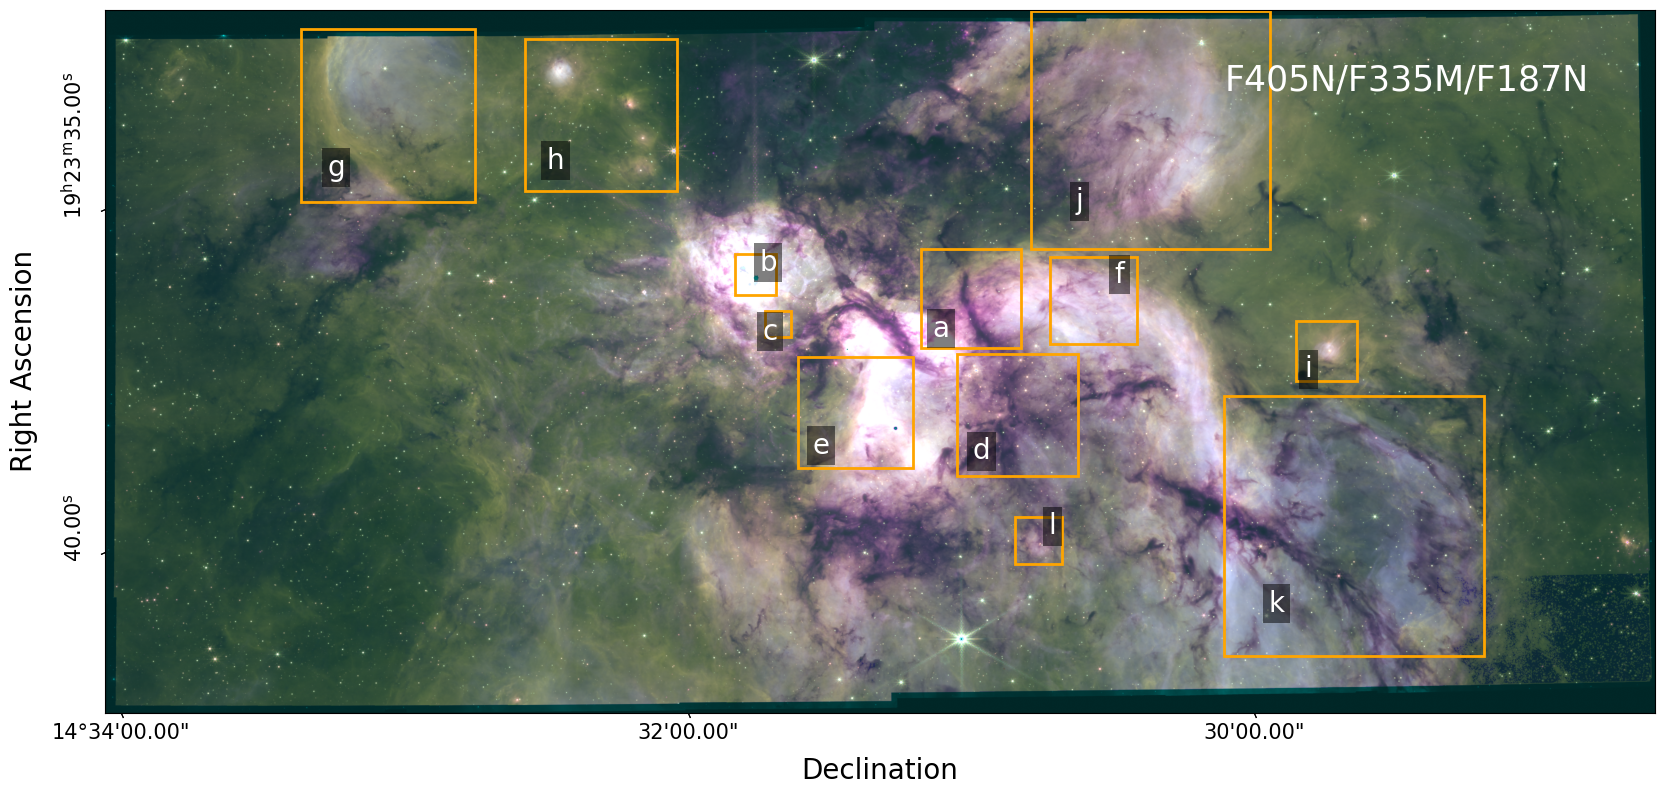

In [26]:
from regions import Regions

plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plot_params = {
     0: #dust filament
   {'filt1': 'f480m', 'filt2': 'f360m', 'filt3': 'f210m',
     'alpha_red': 1, 'alpha_green': 1, 'alpha_blue': 1,
     'vmin_img1': 0.09660550444184562, 'vmax_img1': 1750.5999232117263,
     'vmin_img2':0.004751104975596244, 'vmax_img2': 1526.653229560062,
     'vmin_img3': -1.221155232132053, 'vmax_img3': 940.7141462681723,
     'color_scheme': 'rgb', 'stretch': 'log',
      'swap_width_height': False,
      'xtext':'left', 'ytext':'bottom'},
    
    3: #W51-E
    {'filt1': 'f480m', 'filt2': 'f360m', 'filt3': 'f210m',
     'alpha_red': 1, 'alpha_green': 1, 'alpha_blue': 1,
     'vmin_img1': 0.09660550444184562, 'vmax_img1': 1750.5999232117263,
     'vmin_img2':0.004751104975596244, 'vmax_img2': 1526.653229560062,
     'vmin_img3': -1.221155232132053, 'vmax_img3': 940.7141462681723,
     'color_scheme': 'rgb', 'stretch': 'log',
      'swap_width_height': False,
      'xtext':'left', 'ytext':'bottom'},

     1: #W51-IRS2 protocluster
     {'filt1': 'f210m', 'filt2': 'f162m', 'filt3': 'f140m',
     'alpha_red': 0.8, 'alpha_green': 1, 'alpha_blue': 1,
     'vmin_img1': -1.221155232132053, 'vmax_img1': 940.7141462681723,
     'vmin_img2': -2.4175924704876994, 'vmax_img2': 1294.5471159477977,
     'vmin_img3': -2.744981807184941, 'vmax_img3': 1462.0584667056999,
     'color_scheme': 'rgb', 'stretch': 'log',
      'swap_width_height': False,
      'xtext':'right', 'ytext':'top'},

     2: #proplyds
    {'filt1': 'f335m', 'filt2': 'f405n', 'filt3': 'f480m',
     'alpha_red': 1, 'alpha_green': 1, 'alpha_blue': 1,
     'vmin_img1': 0.009660550444190055, 'vmax_img1': 600.5990491403509,
     'vmin_img2':0.04267011225633506, 'vmax_img2': 1063.1237304389847,
     'vmin_img3': 0.003364086562473228, 'vmax_img3': 385.27355535988465,
     'color_scheme': 'rgb', 'stretch': 'linear',
     'swap_width_height': False,
     'xtext':'left', 'ytext':'bottom'},

     4: #bar
    {'filt1': 'f480m', 'filt2': 'f405n', 'filt3': 'f335m',
     'alpha_red': 1, 'alpha_green': 1, 'alpha_blue': 1,
     'vmin_img1': 0.009660550444190055, 'vmax_img1': 5828.472519101632,
     'vmin_img2':0.004267011225635932, 'vmax_img2': 20562.836733101874,
     'vmin_img3': 0.003364086562473228, 'vmax_img3': 2251.577189723605,
     'color_scheme': 'rgb', 'stretch': 'log',
      'swap_width_height': False,
      'xtext':'left', 'ytext':'bottom'},



       5: #W51 IRS1 HII shell
    {'filt1': 'f405n', 'filt2': 'f335m', 'filt3': 'f187n',
     'alpha_red': 0.86, 'alpha_green': 0.89, 'alpha_blue': 1,
     'vmin_img1': 0.04267011225633506, 'vmax_img1': 11958,
     'vmin_img2': 0.003364086562473228, 'vmax_img2': 3485.013020259365,
     'vmin_img3': -17.33440439109981, 'vmax_img3': 9074.803012534647,
     'color_scheme': 'cmyk', 'stretch': 'log',
      'swap_width_height': False,
      'xtext':'right', 'ytext':'top'},


    6: #w51b1
    {'filt1': 'f405n', 'filt2': 'f335m', 'filt3': 'f187n',
     'alpha_red': 0.86, 'alpha_green': 0.89, 'alpha_blue': 1,
     'vmin_img1': 0.04267011225633506, 'vmax_img1': 11958,
     'vmin_img2': 0.003364086562473228, 'vmax_img2': 3485.013020259365,
     'vmin_img3': -17.33440439109981, 'vmax_img3': 9074.803012534647,
     'color_scheme': 'cmyk', 'stretch': 'log',
      'swap_width_height': False,
      'xtext':'left', 'ytext':'bottom'}, 
    7:  #w51b2
    {'filt1': 'f405n', 'filt2': 'f335m', 'filt3': 'f187n',
     'alpha_red': 0.86, 'alpha_green': 0.89, 'alpha_blue': 1,
     'vmin_img1': 0.04267011225633506, 'vmax_img1': 11958,
     'vmin_img2': 0.003364086562473228, 'vmax_img2': 3485.013020259365,
     'vmin_img3': -17.33440439109981, 'vmax_img3': 9074.803012534647,
     'color_scheme': 'cmyk', 'stretch': 'log',
      'swap_width_height': False,
      'xtext':'left', 'ytext':'bottom'},

    #2:
    #{'filt1': 'f405n', 'filt2': 'f335m', 'filt3': 'f187n',
    # 'alpha_red': 0.86, 'alpha_green': 0.89, 'alpha_blue': 1,
    # 'vmin_img1': 0.04267011225633506, 'vmax_img1': 11958,
    # 'vmin_img2': 0.003364086562473228, 'vmax_img2': 3485.013020259365,
    # 'vmin_img3': -17.33440439109981, 'vmax_img3': 9074.803012534647,
    # 'color_scheme': 'cmyk', 'stretch': 'log',
    #  'swap_width_height': False,
    #  'xtext':'left', 'ytext':'bottom'},
   
    9: #w51c1
    {'filt1': 'f405n', 'filt2': 'f335m', 'filt3': 'f187n',
     'alpha_red': 0.86, 'alpha_green': 0.89, 'alpha_blue': 1,
     'vmin_img1': 0.04267011225633506, 'vmax_img1': 11958,
     'vmin_img2': 0.003364086562473228, 'vmax_img2': 3485.013020259365,
     'vmin_img3': -17.33440439109981, 'vmax_img3': 9074.803012534647,
     'color_scheme': 'cmyk', 'stretch': 'log',
      'swap_width_height': False,
      'xtext':'left', 'ytext':'bottom'},
    #5:
    #,
    
  
   
      8: #w51e7
    {'filt1': 'f405n', 'filt2': 'f335m', 'filt3': 'f187n',
     'alpha_red': 0.86, 'alpha_green': 0.89, 'alpha_blue': 1,
     'vmin_img1': 0.04267011225633506, 'vmax_img1': 11958,
     'vmin_img2': 0.003364086562473228, 'vmax_img2': 3485.013020259365,
     'vmin_img3': -17.33440439109981, 'vmax_img3': 9074.803012534647,
     'color_scheme': 'cmyk', 'stretch': 'log',
      'swap_width_height': False,
      'xtext':'left', 'ytext':'bottom'},
    #    9:
    #{'filt1': 'f480m', 'filt2': 'f360m', 'filt3': 'f210m',
    # 'alpha_red': 1, 'alpha_green': 1, 'alpha_blue': 1,
    # 'vmin_img1': 0.09660550444184562, 'vmax_img1': 1750.5999232117263,
    # 'vmin_img2':0.004751104975596244, 'vmax_img2': 1526.653229560062,
    # 'vmin_img3': -1.221155232132053, 'vmax_img3': 940.7141462681723,
    # 'color_scheme': 'rgb', 'stretch': 'log',
    #  'swap_width_height': False,
    #  'xtext':'left', 'ytext':'bottom'},
      10: #the HII region
    {'filt1': 'f405n', 'filt2': 'f335m', 'filt3': 'f187n',
     'alpha_red': 0.86, 'alpha_green': 0.89, 'alpha_blue': 1,
     'vmin_img1': 0.04267011225633506, 'vmax_img1': 11958,
     'vmin_img2': 0.003364086562473228, 'vmax_img2': 3485.013020259365,
     'vmin_img3': -17.33440439109981, 'vmax_img3': 9074.803012534647,
     'color_scheme': 'cmyk', 'stretch': 'log',
      'swap_width_height': False,
      'xtext':'left', 'ytext':'bottom'},
      11: #another HII region, 2100 blob
    {'filt1': 'f2100w', 'filt2': 'f480m', 'filt3': 'f335m',
      'alpha_red': 1, 'alpha_green': 1, 'alpha_blue': 1,
      'vmin_img1': -402.17527272368216, 'vmax_img1': 233335.9150405763,
      'vmin_img2':0.009660550444190055, 'vmax_img2': 3401.903426111472,
      'vmin_img3': 0.003364086562473228, 'vmax_img3': 1598.902261375355,
      'color_scheme': 'rgb', 'stretch': 'log',
      'swap_width_height': False,
      'xtext':'right', 'ytext':'top'} 
    }
fits405410 = fits.open("/orange/adamginsburg/jwst/w51/filter_subtractions/f405n_minus_f410m.fits")
img405410 = fits.getdata("/orange/adamginsburg/jwst/w51/filter_subtractions/f405n_minus_f410m.fits")
img405410_header = fits.getheader("/orange/adamginsburg/jwst/w51/filter_subtractions/f405n_minus_f410m.fits", ext=('SCI', 1))
wcs405410 = WCS(img405410_header)




highlight_regs = Regions.read('regions/highlight_overview.reg', format='ds9')
highlight_regs_copied = []
idx = [0, 2, 3, 1, 4, 5, 6, 7, 8, 9, 10, 11]
for i in range(len(highlight_regs)):
    highlight_regs_copied.append(highlight_regs[idx[i]])

highlight_regs = highlight_regs_copied
#highlight_regs = sorted(highlight_regs, key=lambda x: x.center.ra)
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

fig = plt.figure(figsize=(20,18))
#gs = gridspec.GridSpec(2, 1, figure=fig, hspace=0.05, wspace=0.05,)
ax_main = fig.add_subplot(111, projection=wcs_header)



ax_main.imshow(rgbimage_overview, origin='lower', )

ax_main.text(0.84,0.9,'F405N/F335M/F187N', color='white', fontsize=25, ha='center', va='center', transform=ax_main.transAxes, )

ra = lon = ax_main.coords['ra']
dec = lat = ax_main.coords['dec']
ra.set_major_formatter('hh:mm:ss.ss')
dec.set_major_formatter('dd:mm:ss.ss')
ra.set_axislabel('Right Ascension',fontsize=20)
ra.set_ticklabel(rotation=90, pad=10)
dec.set_axislabel('Declination',fontsize=20)

ra.set_ticks_position('l')
ra.set_ticklabel_position('l')
ra.set_axislabel_position('l')
dec.set_ticks_position('b')
dec.set_ticklabel_position('b')
dec.set_axislabel_position('b')


for i, reg in enumerate(highlight_regs):
  reg_pix = reg.to_pixel(wcs_header)
  reg_pix.angle= 0 *u.deg
  reg_pix.plot(ax=ax_main, facecolor='none', edgecolor='orange', lw=2, label=labels[i])
  if plot_params[i]['xtext'] == 'left':
      x_text = reg_pix.center.x - 0.3 * reg_pix.width
  else:
      x_text = reg_pix.center.x + 0.3 * reg_pix.width
  if plot_params[i]['ytext'] == 'bottom':
      y_text = reg_pix.center.y - 0.3 * reg_pix.height
  else:
      y_text = reg_pix.center.y + 0.3 * reg_pix.height
  ax_main.text(x_text, y_text, labels[i], color='white', fontsize=20, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'),)
labels2=['A', 'B']
#reg_highlight_405410 = Regions.read('regions/405410highlights.reg', format='ds9')
#for i, reg in enumerate(reg_highlight_405410):
#  reg_pix = reg.to_pixel(wcs_header)
#  reg_pix.plot(ax=ax_main, facecolor='none', edgecolor='yellow', lw=2, label=labels2[i])

 # ax_main.text(reg_pix.center.x - 0.3 * reg_pix.width, reg_pix.center.y + 0.3 * reg_pix.height, labels2[i], color='yellow', fontsize=20, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'),)
"""

ax_main2 = fig.add_subplot(gs[1, 0], projection=wcs_header)
ax_main2.imshow(rgbimage_overview2, origin='lower', )
ax_main2.text(0.8,0.9,'F405N-F410M/F335M/F162M', color='white', fontsize=25, ha='center', va='center', transform=ax_main2.transAxes, )
ra = lon = ax_main2.coords['ra']
dec = lat = ax_main2.coords['dec']
ra.set_major_formatter('hh:mm:ss.ss')
dec.set_major_formatter('dd:mm:ss.ss')
ra.set_axislabel('Right Ascension',fontsize=20)
ra.set_ticklabel(rotation=90, pad=10)
dec.set_axislabel('Declination',fontsize=20)

ra.set_ticks_position('l')
ra.set_ticklabel_position('l')
ra.set_axislabel_position('l')
dec.set_ticks_position('b')
dec.set_ticklabel_position('b')
dec.set_axislabel_position('b')


"""


fig.savefig('plots/highlights_total.png', dpi=100, bbox_inches='tight')


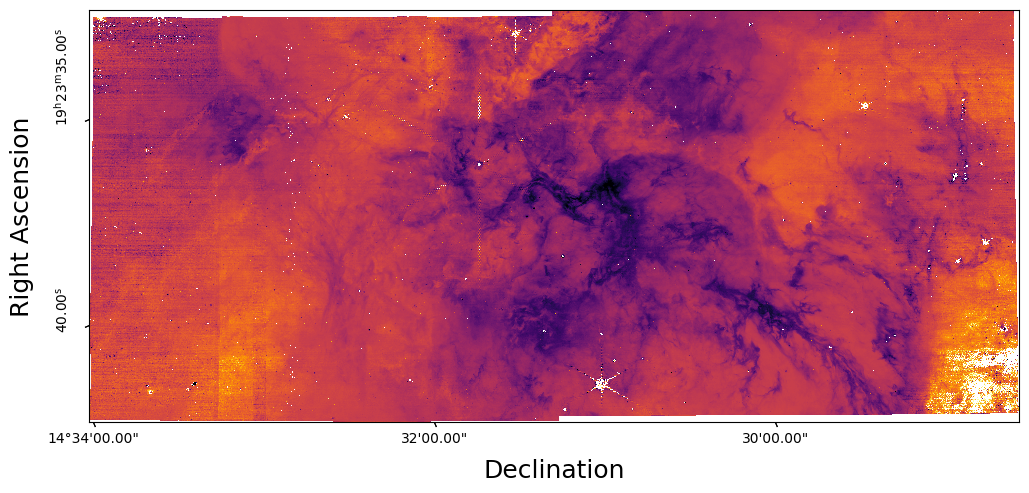

In [23]:
plt.rcParams['axes.labelsize']=10
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
fitspaabra = fits.open("/orange/adamginsburg/jwst/w51/filter_subtractions/paa_bra_ratio_non_neg.fits")
img_spaabra = fits.getdata("/orange/adamginsburg/jwst/w51/filter_subtractions/paa_bra_ratio_non_neg.fits")
img_spaabra_header = fits.getheader("/orange/adamginsburg/jwst/w51/filter_subtractions/paa_bra_ratio_non_neg.fits", ext=('SCI', 1))
wcs_spaabra = WCS(img_spaabra_header)   
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(111, projection=wcs405410)
norm_spaabra = simple_norm(img_spaabra, stretch='log', vmin=0.012819076175867184, vmax=16.91677460506177)
ax1.imshow(img_spaabra, origin='lower', interpolation='nearest', cmap='inferno', norm=norm_spaabra)

ra = lon = ax1.coords['ra']
dec = lat = ax1.coords['dec']
ra.set_major_formatter('hh:mm:ss.ss')
dec.set_major_formatter('dd:mm:ss.ss')
ra.set_axislabel('Right Ascension',fontsize=18)
ra.set_ticklabel(rotation=90, pad=10)
dec.set_axislabel('Declination',fontsize=18)

ra.set_ticks_position('l')
ra.set_ticklabel_position('l')
ra.set_axislabel_position('l')
dec.set_ticks_position('b')
dec.set_ticklabel_position('b')
dec.set_axislabel_position('b')
plt.savefig('plots/paabra_ratio.png', dpi=100, bbox_inches='tight')

80.6164830853158
80.6164830853158


/scratch/local/10812130/ipykernel_1732694/3601743554.py:48: MatplotlibDeprecationWarning: the (unused) 'frac' key in 'arrowprops' was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  ax.annotate('IRS2E', xy=(0.54,0.45), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
/scratch/local/10812130/ipykernel_1732694/3601743554.py:50: MatplotlibDeprecationWarning: the (unused) 'frac' key in 'arrowprops' was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  ax.annotate('IRS2W', xy=(0.14,0.57), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,


80.6164830853158


/scratch/local/10812130/ipykernel_1732694/3601743554.py:56: MatplotlibDeprecationWarning: the (unused) 'frac' key in 'arrowprops' was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  ax.annotate('cometary objects?', xy=(0.38,0.5), xycoords='axes fraction', color='white', fontsize=18, ha='right', va='center', transform=ax.transAxes,
/scratch/local/10812130/ipykernel_1732694/3601743554.py:58: MatplotlibDeprecationWarning: the (unused) 'frac' key in 'arrowprops' was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  ax.annotate('', xy=(0.72,0.57), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,


80.6164830853158
80.6164830853158
80.6164830853158
80.6164830853158


/scratch/local/10812130/ipykernel_1732694/3601743554.py:68: MatplotlibDeprecationWarning: the (unused) 'frac' key in 'arrowprops' was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  ax.annotate('O9.5 star',xy=(0.48,0.75), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
/scratch/local/10812130/ipykernel_1732694/3601743554.py:70: MatplotlibDeprecationWarning: the (unused) 'frac' key in 'arrowprops' was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  ax.annotate('wrinkle?', xy=(0.2,0.8), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
/scratch/local/10812130/ipykernel_1732694/3601743554.py:72: MatplotlibDeprecationWarning: the (unused) 'frac' key in 'arrowprops' was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  ax.annotate('W51b1 HII region', xy=(0.4,0.6), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transf

80.6164830853158


/scratch/local/10812130/ipykernel_1732694/3601743554.py:75: MatplotlibDeprecationWarning: the (unused) 'frac' key in 'arrowprops' was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  ax.annotate('W51b2 HII region\n+O9.5 star',xy=(0.25,0.7), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
/scratch/local/10812130/ipykernel_1732694/3601743554.py:77: MatplotlibDeprecationWarning: the (unused) 'frac' key in 'arrowprops' was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  ax.annotate('YSO', xy=(0.6,0.55), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
/scratch/local/10812130/ipykernel_1732694/3601743554.py:79: MatplotlibDeprecationWarning: the (unused) 'frac' key in 'arrowprops' was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  ax.annotate('', xy=(0.7,0.37), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transfo

80.6164830853158
80.6164830853158
80.6164830853158
80.6164830853158


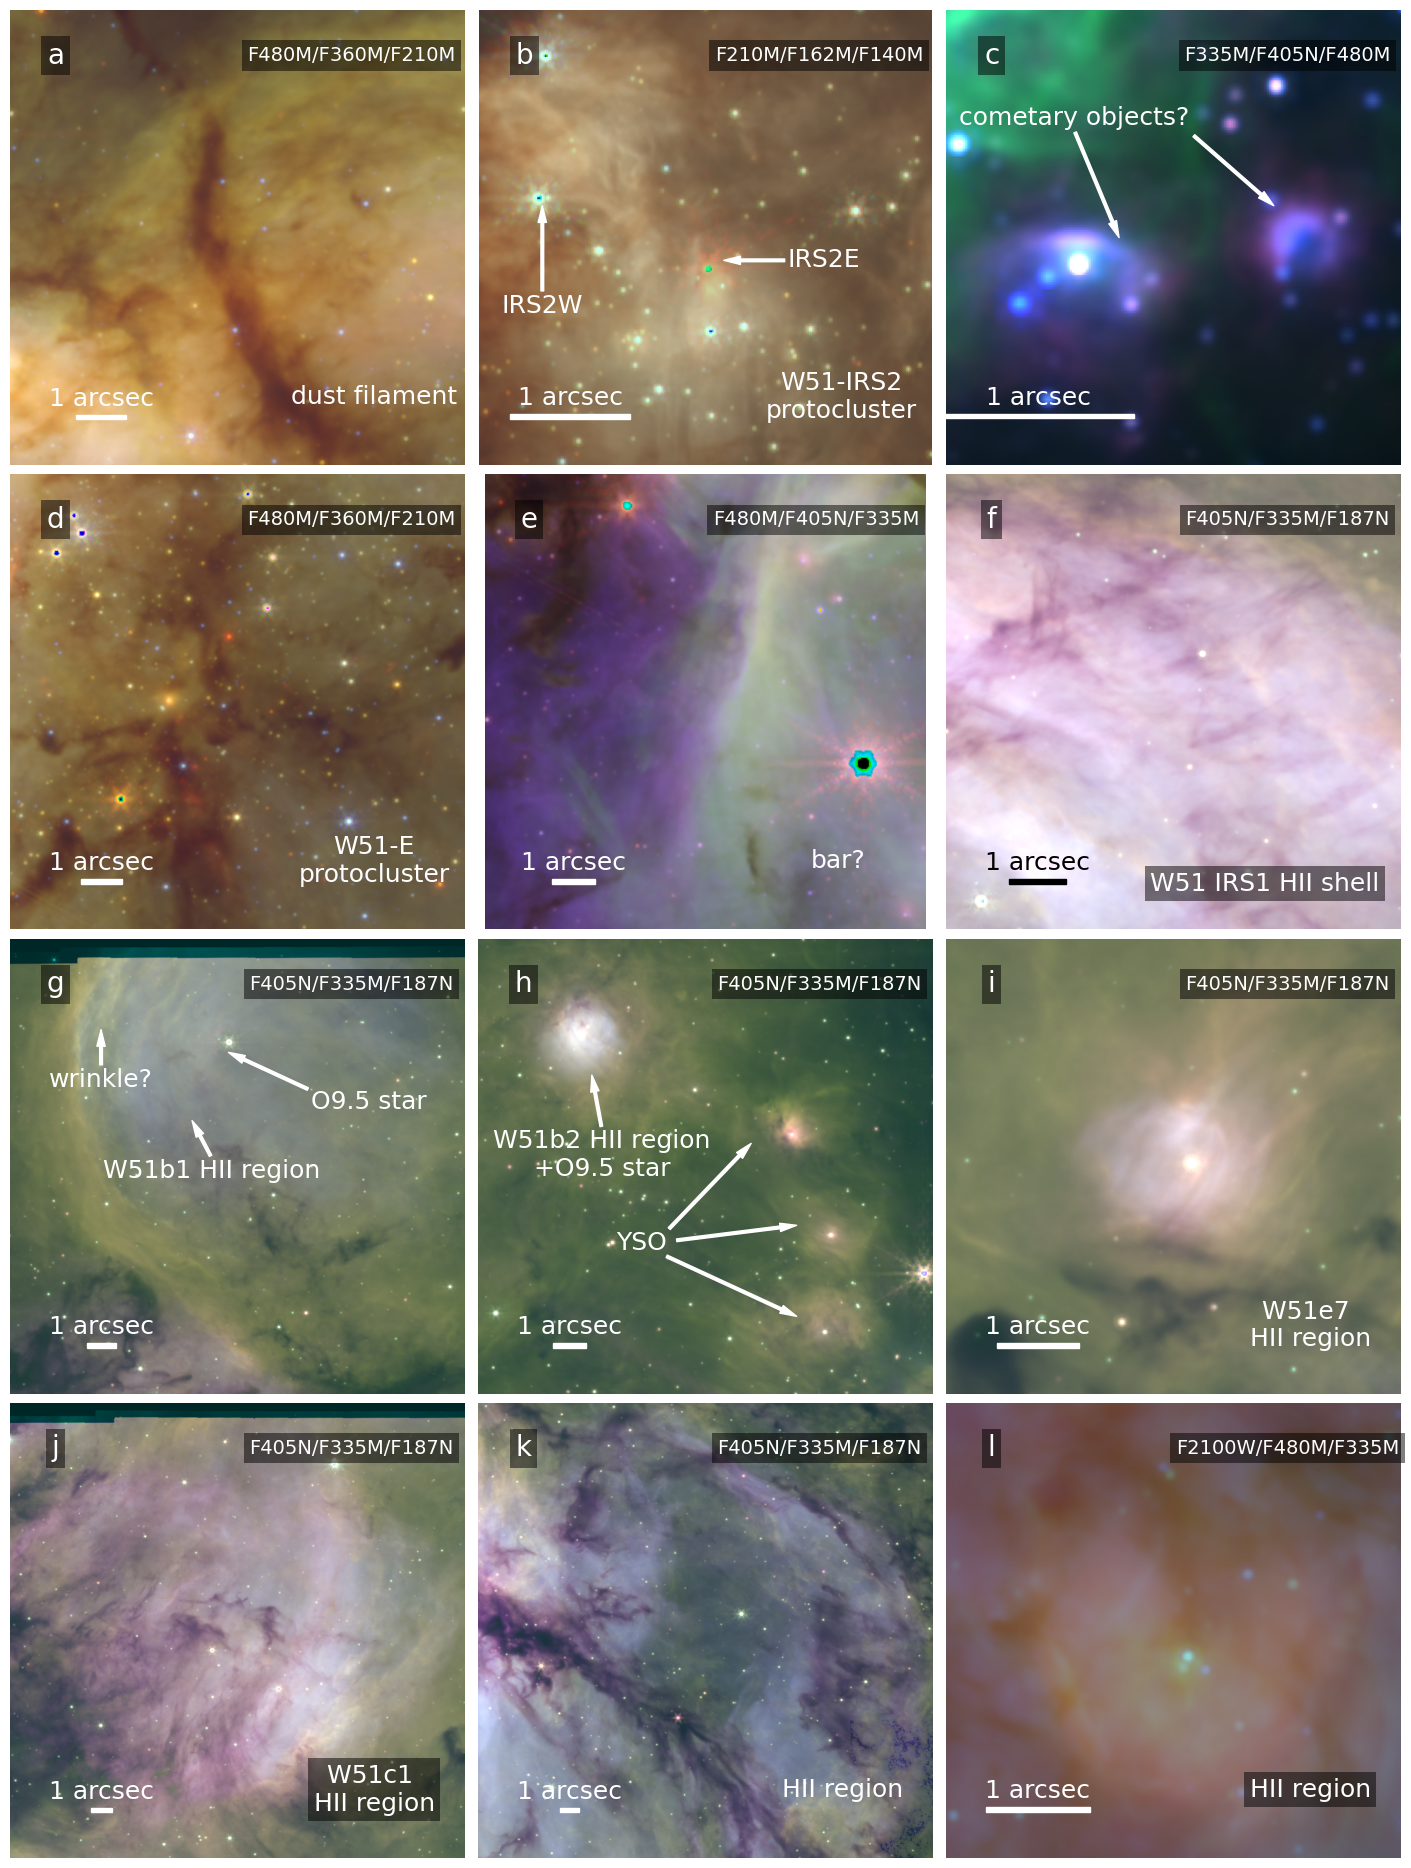

In [30]:
def add_scalebar(ax, xpos, ypos, length, pixel_scale, label=None, color='white', fontsize=20, bbox=False, pad=0.05, thickness=5):

    scaled_length = (length / pixel_scale).to(u.deg/u.deg)
    print(scaled_length)
    ax.add_patch(Rectangle((xpos-scaled_length.value/2, ypos), scaled_length.value, thickness, color=color))
    if label:
        if bbox:
            ax.text(xpos, ypos + pad, label, color=color, fontsize=fontsize, ha='center', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        else:
            ax.text(xpos, ypos + pad, label, color=color, fontsize=fontsize, ha='center')

ind =0
fig = plt.figure(figsize=(18,24))
gs = gridspec.GridSpec(4, 3, figure=fig, hspace=0.02, wspace=0.02, )
for i in range(4):
    for j in range(3):
        
        ax = fig.add_subplot(gs[i,j], projection=wcs_header)
        cutout, cutout_wcs = make_rgb_image(repr140_image_filenames,
                                plot_params[ind]['filt1'], plot_params[ind]['filt2'], plot_params[ind]['filt3'],
                                alpha_red=plot_params[ind]['alpha_red'], alpha_green=plot_params[ind]['alpha_green'], 
                                alpha_blue=plot_params[ind]['alpha_blue'],
                                vmin_img1=plot_params[ind]['vmin_img1'], vmax_img1=plot_params[ind]['vmax_img1'],
                                vmin_img2=plot_params[ind]['vmin_img2'], vmax_img2=plot_params[ind]['vmax_img2'],
                                vmin_img3=plot_params[ind]['vmin_img3'], vmax_img3=plot_params[ind]['vmax_img3'],
                                color_scheme=plot_params[ind]['color_scheme'], stretch=plot_params[ind]['stretch'],
                                ax=ax, swap_width_height=plot_params[ind]['swap_width_height'], cutout_region=highlight_regs[ind],)
        ax.text(0.1,0.9, labels[ind], color='white', fontsize=20, ha='center', va='center', transform=ax.transAxes, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        ax.text(0.75,0.9, f"{plot_params[ind]['filt1'].upper()}/{plot_params[ind]['filt2'].upper()}/{plot_params[ind]['filt3'].upper()}", color='white', fontsize=14, ha='center', va='center', transform=ax.transAxes, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        ax.xaxis.label.set_visible(False)

        ax.yaxis.label.set_visible(False)
        ax.set_axis_off()

        ax.coords.grid(False)
        cutout_pixel_scale = np.abs(cutout_wcs.pixel_scale_matrix[0,0])*u.deg
        if ind ==5:
            add_scalebar(ax, 0.2*cutout.shape[1], 0.1*cutout.shape[0], 1 * u.arcsec, pixel_scale=cutout_pixel_scale, label='1 arcsec', color='black', fontsize=18, thickness=cutout.shape[1]*0.01, pad=cutout.shape[1]*0.03)
        else:
            add_scalebar(ax, 0.2*cutout.shape[1], 0.1*cutout.shape[0], 1 * u.arcsec, pixel_scale=cutout_pixel_scale, label='1 arcsec', color='white', fontsize=18, thickness=cutout.shape[1]*0.01, pad=cutout.shape[1]*0.03)


        if ind == 0:
            ax.text(0.8,0.15, 'dust filament', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes, )
        elif ind == 3:
            ax.text(0.8,0.15, 'W51-E\nprotocluster', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes, )
        elif ind == 1: #IRS2
            ax.annotate('IRS2E', xy=(0.54,0.45), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
            arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(100,0))
            ax.annotate('IRS2W', xy=(0.14,0.57), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
            arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(0, -100))
            ax.text(0.8,0.15,'W51-IRS2\nprotocluster', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes, )
        elif ind == 2:
            #ax.annotate('proplyds?', xy=(0.3,0.83), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
            #arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(150,-40))
            ax.annotate('cometary objects?', xy=(0.38,0.5), xycoords='axes fraction', color='white', fontsize=18, ha='right', va='center', transform=ax.transAxes,
            arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(70,120))
            ax.annotate('', xy=(0.72,0.57), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
            arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(-80,70))
            #ax.annotate('', xy=(0.9,0.57), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
            #arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(-70,70))
         
        elif ind == 4:
            ax.text(0.8,0.15, 'bar?', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes, )
        elif ind == 5:
            ax.text(0.7,0.1, 'W51 IRS1 HII shell', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        elif ind ==6: #w51eb1
            ax.annotate('O9.5 star',xy=(0.48,0.75), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
            arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(140,-50))
            ax.annotate('wrinkle?', xy=(0.2,0.8), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
            arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(0,-50))
            ax.annotate('W51b1 HII region', xy=(0.4,0.6), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
            arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(20,-50))
        elif ind == 7: #w51eb2
            ax.annotate('W51b2 HII region\n+O9.5 star',xy=(0.25,0.7), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
            arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(10,-80))
            ax.annotate('YSO', xy=(0.6,0.55), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
            arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(-110,-100))
            ax.annotate('', xy=(0.7,0.37), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
            arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(-120,-15))
            ax.annotate('', xy=(0.7,0.17), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
            arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(-130,60))
        #if ind == 2:
        #    ax.text(0.8,0.15,'dust ridges', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
            #ax.annotate('dust ridge',xy=(0.5,0.5), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
            #arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(100,-50))
       # if ind == 2:
       #     ax.annotate('outflow knot', xy=(0.51,0.63), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
       #     arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(70,-60))
       #     ax.annotate('ionized gas', xy=(0.25,0.8), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
       #     arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(-20,-180))
       #     ax.annotate('', xy=(0.4,0.57), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
       #     arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(-40,-50))
            #ax.annotate('', xy=(0.6,0.3), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
            #arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(-95,35))
       #     ax.annotate('', xy=(0.6,0.1), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
       #     arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(-180,130))
        
        elif ind == 8:
            ax.text(0.8,0.15, 'W51e7 \nHII region', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,)
        elif ind == 9: #w51c1
            ax.text(0.8,0.15,'W51c1 \nHII region', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))

        elif ind==11:
            ax.text(0.8,0.15,'HII region', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
       
        
      
        
       # elif ind == 9:
       #     ax.annotate('bipolar outflow', xy=(0.6,0.6), xycoords='axes fraction', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes,
       #     arrowprops=dict( color='white', width=2,headwidth=6, frac=0.05, ec='w', fc='w'), textcoords='offset pixels', xytext=(80,80))
        elif ind ==10:
            ax.text(0.8,0.15, 'HII region', color='white', fontsize=18, ha='center', va='center', transform=ax.transAxes, )
        ind = ind+1

fig.savefig('plots/highlights_cutouts.png', dpi=100, bbox_inches='tight')


NameError: name 'reg_highlight_405410' is not defined

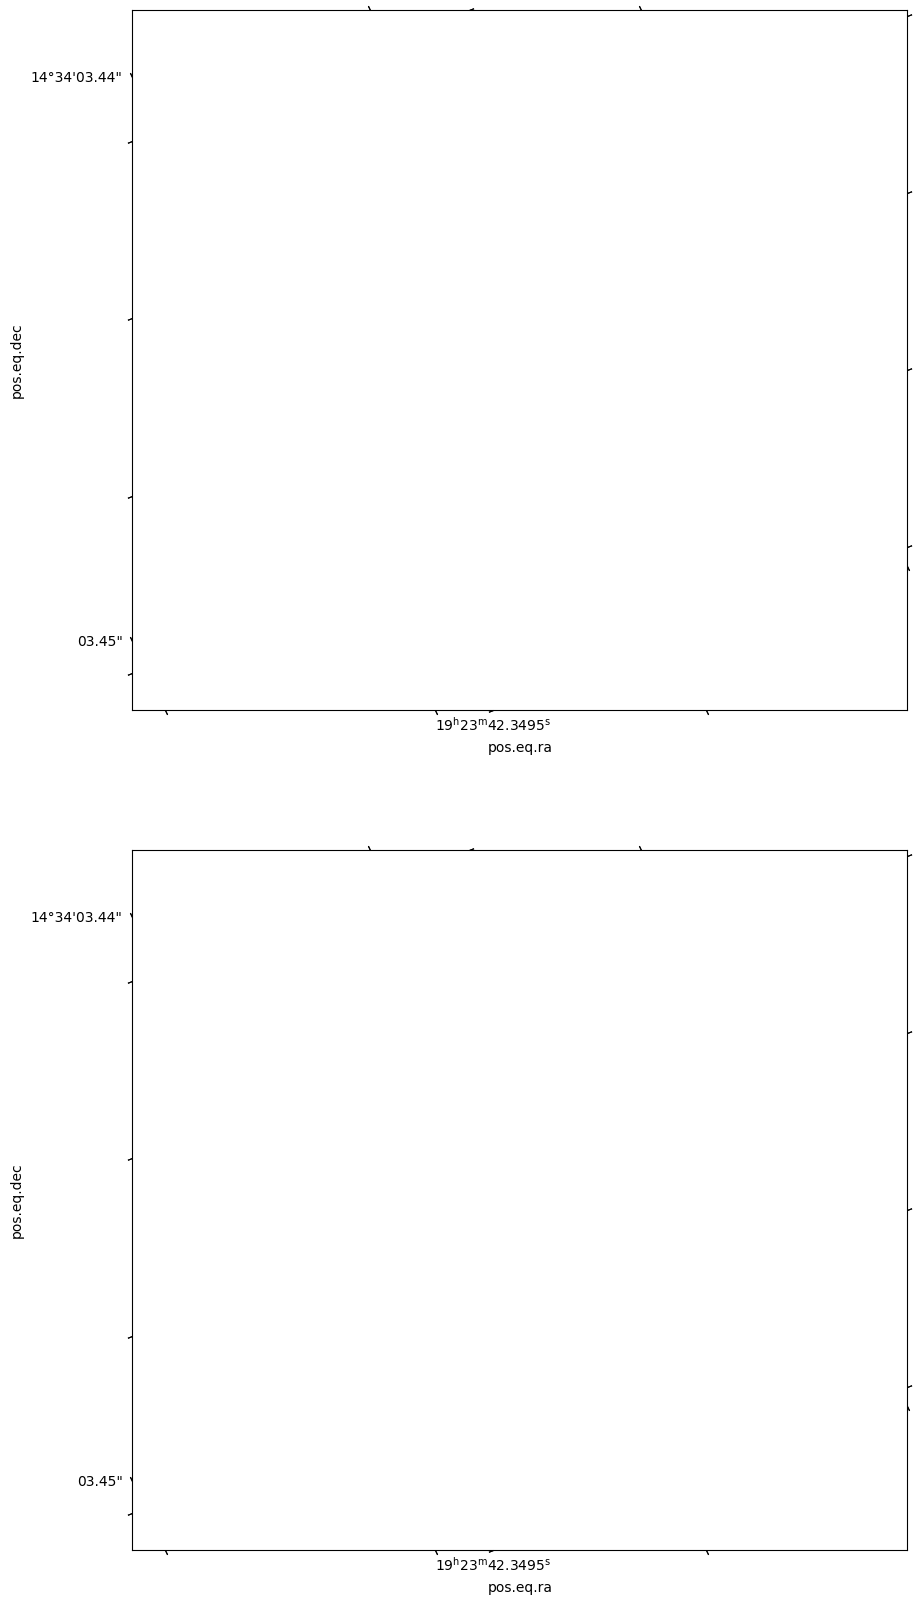

In [25]:

fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(211, projection=wcs_header)
ax2 = fig.add_subplot(212, projection=wcs_header)

rgbimage405410_cutout1 = make_rgb_image(repr140_image_filenames, 'f405n-f410m', 'f162m', 'f335m', alpha_red=1, alpha_green=1, alpha_blue=1, figsize=(48,20),
vmin_img1=-1.753765709595882, vmax_img1=3519.713512861117, vmin_img3=0.003364086562473228, vmax_img3=2325.749575870834, vmin_img2=-2.358460483000785, vmax_img2=1024.21273175457, color_scheme='rgb', cutout_region=reg_highlight_405410[0],)
rgbimage405410_cutout2 = make_rgb_image(repr140_image_filenames, 'f405n-f410m', 'f162m', 'f335m', alpha_red=1, alpha_green=1, alpha_blue=1, figsize=(48,20),
vmin_img1=-1.753765709595882, vmax_img1=3519.713512861117, vmin_img3=0.003364086562473228, vmax_img3=2325.749575870834, vmin_img2=-2.358460483000785, vmax_img2=1024.21273175457, color_scheme='rgb', cutout_region=reg_highlight_405410[1],)

ax1.imshow(rgbimage405410_cutout1[0], origin='lower', )
ax2.imshow(rgbimage405410_cutout2[0], origin='lower', )

ra = lon = ax1.coords['ra']
dec = lat = ax1.coords['dec']
ra.set_major_formatter('hh:mm:ss.ss')
dec.set_major_formatter('dd:mm:ss.ss')
ra.set_axislabel('Right Ascension',fontsize=20)
ra.set_ticklabel(rotation=90, pad=10)
dec.set_axislabel('Declination',fontsize=20)

ra.set_ticks_position('l')
ra.set_ticklabel_position('l')
ra.set_axislabel_position('l')
dec.set_ticks_position('b')
dec.set_ticklabel_position('b')
dec.set_axislabel_position('b')

ra = lon = ax2.coords['ra']
dec = lat = ax2.coords['dec']
ra.set_major_formatter('hh:mm:ss.ss')
dec.set_major_formatter('dd:mm:ss.ss')
ra.set_axislabel('Right Ascension',fontsize=20)
ra.set_ticklabel(rotation=90, pad=10)
dec.set_axislabel('Declination',fontsize=20)

ra.set_ticks_position('l')
ra.set_ticklabel_position('l')
ra.set_axislabel_position('l')
dec.set_ticks_position('b')
dec.set_ticklabel_position('b')
dec.set_axislabel_position('b')

ax1.text(0.1,0.9, 'A', color='white', fontsize=20, ha='center', va='center', transform=ax1.transAxes, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
ax1.text(0.75,0.9,'F405N-F410M/F162M/F335M', color='white', fontsize=20, ha='center', va='center', transform=ax1.transAxes, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
ax2.text(0.1,0.9, 'B', color='white', fontsize=20, ha='center', va='center', transform=ax2.transAxes, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))


"""
plot_param2 = {0:
{'filt1': 'f405n-f410m', 'filt3': 'f335m', 'filt2': 'f140m',
     'alpha_red': 1, 'alpha_green': 1, 'alpha_blue': 1,
     'vmin_img1':-1.753765709595882, 'vmax_img1': 3519.713512861117,
     'vmin_img3': 0.003364086562473228, 'vmax_img3': 2572.344608334221,
     'vmin_img2': -2.358460483000785, 'vmax_img2': 960.387258888257,
     'color_scheme': 'rgb', 'stretch': 'log',
      'swap_width_height': False,
      'xtext':'left', 'ytext':'bottom'},

    
    1:
    {'filt1': 'f405n-f410m', 'filt3': 'f335m', 'filt2': 'f140m',
     'alpha_red': 1, 'alpha_green': 1, 'alpha_blue': 1,
     'vmin_img1':-1.753765709595882, 'vmax_img1': 3519.713512861117,
     'vmin_img3': 0.003364086562473228, 'vmax_img3': 2572.344608334221,
     'vmin_img2': -2.358460483000785, 'vmax_img2': 960.387258888257,
     'color_scheme': 'rgb', 'stretch': 'log',
      'swap_width_height': False,
      'xtext':'left', 'ytext':'bottom'},}
"""
plt.savefig('plots/405410_cutouts.png', dpi=100, bbox_inches='tight')